The Code is compatible to run with both CPU and GPU. Make sure you install the libraries numpy,matplotlib,numba,open-cv before running the code.

# Continuous 3D Label Stereo Matching using Local Expansion Moves(LocalExp)
**(Task-1:: Pick any of the high ranking matching algorithms in the top 20, : Pick any of the high ranking matching algorithms in the top 20  )**<br><br>
In the algorithm which we used for the assignment we assumed that the disparity is there is ony x-direction and if there is a disparity in both direction we did stero-rectification to make the disparity present in only one direction. 

But in this paper we consider  disparity to be a function of both x and y coordinate. At every pixel 'p' disparity is given by $$d_{p} = a_{p}x + b_{p}y + c_{p}$$<br>
Our goal is to estimate the parameters $a_{p},b_{p},c_{p}$ for each pixel. <br>

We use a pairwise Markov random fields(MRF) formulation by following conventional stereo matching methods. In the MRF framework, each pixel p is assigned
a value in some disparity space S(i.e $(a_{p},b_{p},c_{p})$ ∈ 'S'), and one seeks a disparity map f for every pixel fp = f(p) : P → S that minimizes the below function:<br>
$$ E(f)=\sum\limits_{p\epsilon P} {\phi_{p}(f_{p})}+\sum\limits_{p\epsilon P} {\sum\limits_{q \epsilon N(p)}\psi_{pq}(f_{p},f_{q}) }$$<br>
The first term in the equation is the  data term or unary term, measures the photo-consistency between matching pixels. The disparity fp defines a warp from a pixel p in one image to its correspondence in the other image. The second term is called the smoothness term or pairwise term, which penalizes discontinuity of disparities of a pixel p and its neighboring pixels q ∈ N (p).<br>

The main contribution of this paper is it introduces locally shared labels for efficiently optimizing continuous MRFs. The locally shared labels are the combination of
pixel and region label. Pixel labels are a small number
 of discrete disparity labels (or candidate labels) defined at each pixel p, which we refer to as a pixel label. $L_{p}=[l_{p}^0,l_{p}^0,l_{p}^0,....l_{p}^k] $where $l_{p}^i=(a,b,c)^T$<br>
We define region labels(For the sets of pixels)$R_{r}$  that give additional candidate labels for accelerating spatial propagation and avoiding stuck at a local minimum.<br><br>
**Optimization:**<br>
At first we randomy initialize $R_{r},L_{p}$. We optimize the labeling f by
approximately solving the sequentially fusing proposals constructed from pixel and region label sets $L_{p}$ and $R_{r}$ using the below formula.<br><br>
$f^t=argminE(f)$ with local label sets $R_{r},L_{p}$<br>

Then we iterate through every pixel and update the $L_{p}$ through pertubation. Later we iterate through region labels and  as
done in the initialization, we again take a random-pick-up
scheme. This time, the current solution $f_{p}^t$ of randomly
chosen pixels p is taken as the region labels.
Finally, after the whole process, we perform the postprocessing using left-right consistency check and median
filtering for further improving the results.

$@inproceedings{Taniai14,
  author    = {Tatsunori Taniai and
               Yasuyuki Matsushita and
               Takeshi Naemura},
  title     = {{Continuous Stereo Matching using Locally Shared Labels}},
  booktitle = {{IEEE Conference on Computer Vision and Pattern Recognition (CVPR)}},
  year      = {2014},
  pages     = {1613--1620},
}$

In [1]:
from PIL import Image
import numpy as np
from pylab import *
import cv2
import matplotlib.pyplot as plt
from numba import jit

The performance of our depth map is evaluated by comparing it with a ground-truth disparity map as showm in below formula<br>
$Accuracy(z,z*) =$${1 \over Z}\sum\limits_{x=1}^{W} {\sum\limits_{y=1}^{H} } 
\left\{
    \begin{array}{ll}
        1  & \mbox{if } |z(x,y)-z*(x,y)| <Thershold \\
        {0} & else
    \end{array}
\right.$<br>
Where
z is the depth map estimated
z* is ground truth
Z is number of pixels
(W,H) width and height of images

The above formula is coded in below function. 

In [2]:
def badpixel_count(disparity,groundtruth): #Return the percentage of correct pixels
   
   
    correct = np.count_nonzero(np.abs(disparity - groundtruth) <= 10)
    return (float(correct) / groundtruth.size)*100

# Sum of absolute differences(SAD):
In the sum of absolute differences method the matching of two patches p and q is penalised depending on
the sum of absolute differences of the two windows according to the below formula<br>
$SAD(p,q) =$$\sum\limits_{x=1}^{W} {\sum\limits_{y=1}^{H} } 
|p(x,y)=q(x,y)|.$<br>

# Cost Volume:
We use the SSD similarity method to compute the cost-volume CV for a pre-defined range of disparities D according to the below formula<br>
CV (x, y, d) = SSD(ImageLeft(x, y),ImageRight(x − d, y))<br><br>
This basically means that we take the left picture and translate the right picture trying to overlap
the objects in the two pictures taken from different views. The points at a certain depth have a certain
disparity and thus the optimal shift can be used to determine the correct depth. In order to account
for a certain deviation we use a certain search window (W, H) rather than trying to match the points
directly.<br>

# Algorithm:
After finding the cost volume we will obtain the best disparity for each image point by taking the point with
the lowest value in the cost volume along the disparity axis according to the below formula<br>
$$d(x, y) =arg min_{d}CV (x, y, d)$$ 

In [3]:
@jit(nopython = True, parallel = True, cache = True)
def disparity_estimation(imgl,imgr, D, R):
    
    """
    Estimate the disparity given the maximum disparity D to be cosidered with neighbourhood raidus 'rad' with Sum of Absolute Differences (SAD)
        imgl:  left input image of size (H,W)
        imgr:  right input image of size (H,W)
        D:           maximum disparity to be considered
        R:           radius of the filter
       return:      CostVolume with dimension (H,W,D)
    """
    
    
    (H,W) = imgl.shape
    cv    = np.zeros((H,W,D))  # cost volume of size (H,W,D)
    
    # Loop over the image
    for y in range(R, H - R):
        for x in range(R, W - R):
            
            # Loop over the window
            for v in range(-R, R + 1):
                for u in range(-R, R + 1):
                    
                    # Loop over all possible disparities
                    for d in range(0, D):
                        if(y+v<imgl.shape[0] and x+u+d<imgl.shape[1]):
                            aa=np.absolute(imgl[y+v, x+u] - imgr[y+v, x+u+d])
                            cv[y,x,d] += aa
                               
                            
    return cv

In [4]:
def esp_disp(cv):
    return np.argmin(cv, axis=2)    

# Loading Images

In [5]:
def load_image(address1,address2,address3,address4):
    imgr= cv2.imread(address1, cv2.IMREAD_GRAYSCALE)
    imgl= cv2.imread(address2, cv2.IMREAD_GRAYSCALE)
    displ=cv2.imread(address3, cv2.IMREAD_GRAYSCALE)
    dispr=cv2.imread(address4, cv2.IMREAD_GRAYSCALE)

    imgr=imgr.astype(np.int32)
    imgl=imgl.astype(np.int32)
    displ=displ.astype(np.int32)
    dispr=dispr.astype(np.int32)
    displ=displ/3
    dispr=dispr/3
    return imgr,imgl,dispr,displ

# Estimating the Disparity at various Block Radil

In [6]:
def estimate_at_various_radil(imgl,imgr,displ,rads=[1,2,4,6,8,10,20]):
    accuracies=[]
    for rad in rads:
        cv=disparity_estimation(imgl,imgr,80,rad)
        disp=esp_disp(cv)
        accuracy=badpixel_count(disp,displ)
        accuracies.append(accuracy)
        print("Block Radius= ",rad)
        print("Accuracy= ",accuracy)
        plt.imshow(disp,cmap="gray")
        plt.show()
    return accuracies,rads
    

# ART Dataset

Block Radius=  1
Accuracy=  66.88984881209504


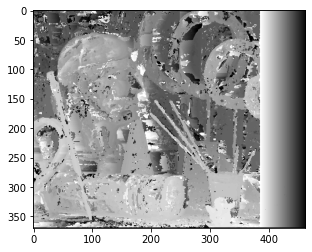

Block Radius=  2
Accuracy=  69.38123869009398


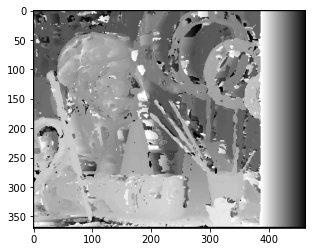

Block Radius=  4
Accuracy=  69.37189889673691


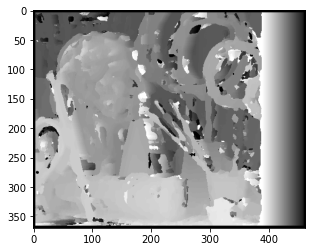

Block Radius=  6
Accuracy=  68.21142957212072


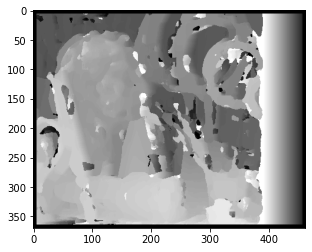

Block Radius=  8
Accuracy=  66.49641001692838


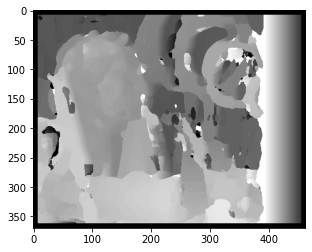

Block Radius=  10
Accuracy=  64.47726344054637


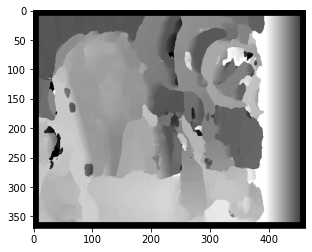

Block Radius=  20
Accuracy=  51.88722199521335


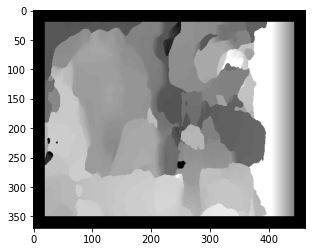

In [7]:

imgr,imgl,dispr,displ=load_image('../input/assignment1/data/Art/view1.png','../input/assignment1/data/Art/view5.png','../input/assignment1/data/Art/disp5.png','../input/assignment1/data/Art/disp1.png')
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


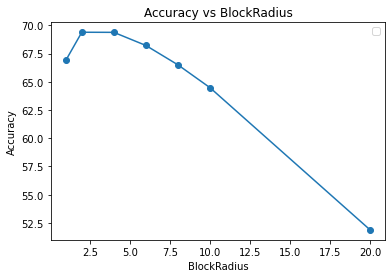

In [8]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 2 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Books Dataset

Block Radius=  1
Accuracy=  66.12340201973032


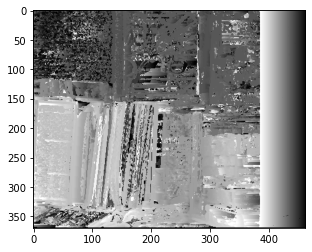

Block Radius=  2
Accuracy=  72.04599848228358


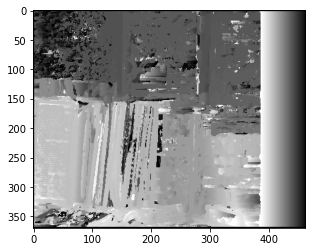

Block Radius=  4
Accuracy=  76.95405989142489


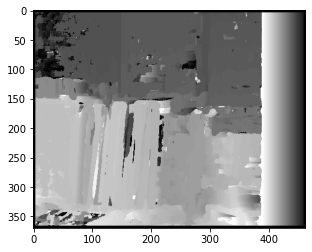

Block Radius=  6
Accuracy=  78.16998423909871


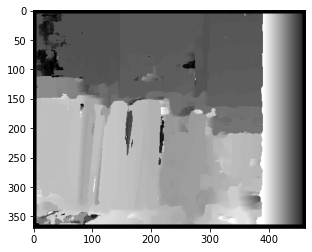

Block Radius=  8
Accuracy=  78.10694063393846


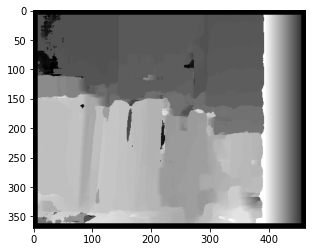

Block Radius=  10
Accuracy=  77.39770007588582


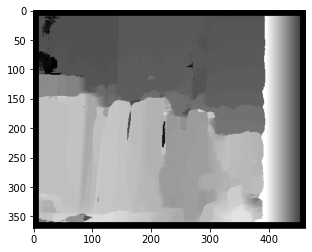

Block Radius=  20
Accuracy=  71.1779814371607


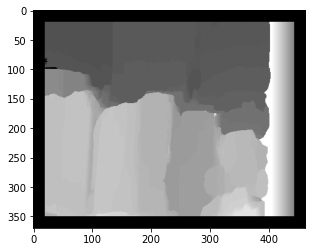

In [9]:

imgr,imgl,dispr,displ=load_image('../input/assignment1/data/Books/view1.png','../input/assignment1/data/Books/view5.png','../input/assignment1/data/Books/disp5.png','../input/assignment1/data/Books/disp1.png')
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


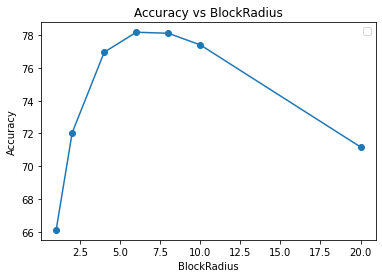

In [10]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 6 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Dolls Dataset

Block Radius=  1
Accuracy=  79.21779230634523


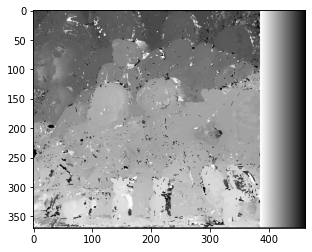

Block Radius=  2
Accuracy=  82.12013309205534


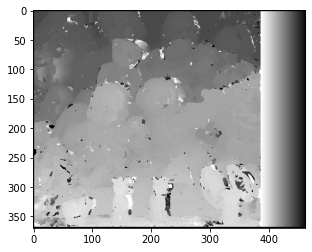

Block Radius=  4
Accuracy=  82.68810927558228


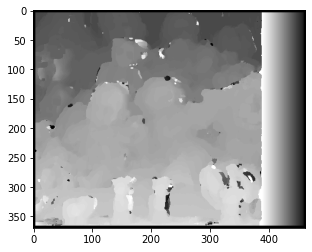

Block Radius=  6
Accuracy=  82.1808417488763


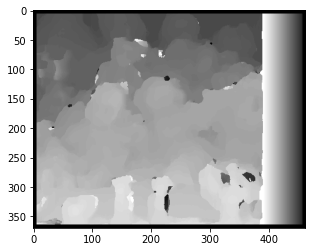

Block Radius=  8
Accuracy=  81.34901640301209


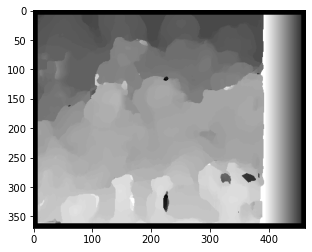

Block Radius=  10
Accuracy=  80.10799136069114


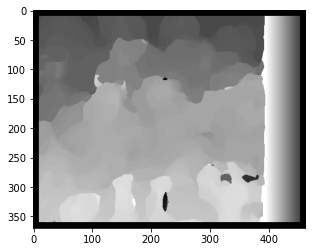

Block Radius=  20
Accuracy=  73.36699550522444


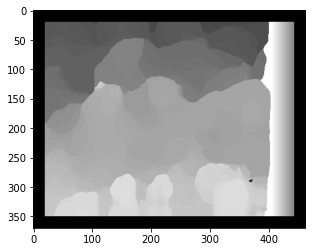

In [11]:
imgr,imgl,dispr,displ=load_image('../input/assignment1/data/Dolls/view1.png','../input/assignment1/data/Dolls/view5.png','../input/assignment1/data/Dolls/disp5.png','../input/assignment1/data/Dolls/disp1.png')
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


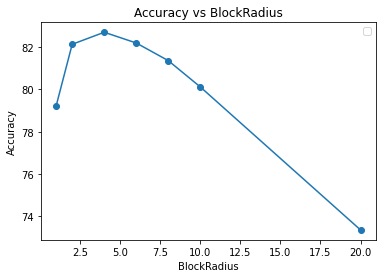

In [12]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 4 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Reindeer Dataset

Block Radius=  1
Accuracy=  68.12987484128423


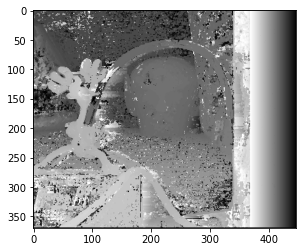

Block Radius=  2
Accuracy=  73.37626216820847


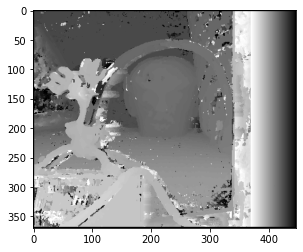

Block Radius=  4
Accuracy=  75.20890017534313


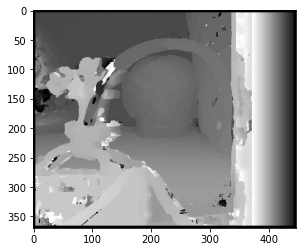

Block Radius=  6
Accuracy=  74.32130116693875


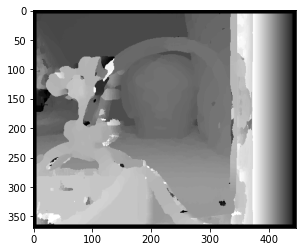

Block Radius=  8
Accuracy=  73.40347058467864


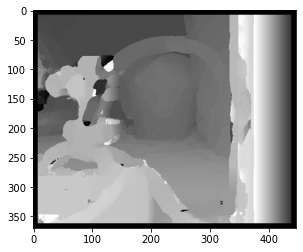

Block Radius=  10
Accuracy=  72.37559707358365


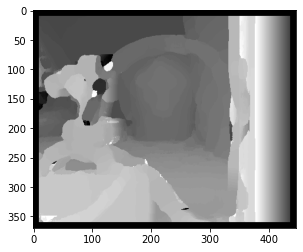

Block Radius=  20
Accuracy=  65.48098434004474


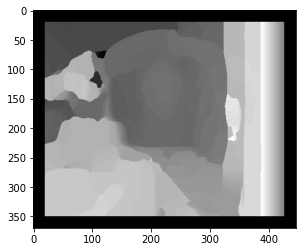

In [13]:
imgr,imgl,dispr,displ=load_image('../input/assignment1/data/Reindeer/view1.png','../input/assignment1/data/Reindeer/view5.png','../input/assignment1/data/Reindeer/disp5.png','../input/assignment1/data/Reindeer/disp1.png')
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


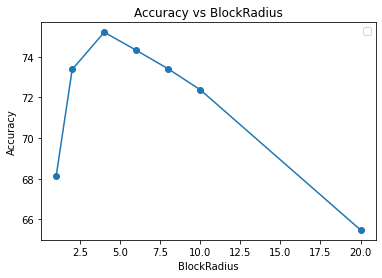

In [14]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 4 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Cones Dataset

Block Radius=  1
Accuracy=  72.0722962962963


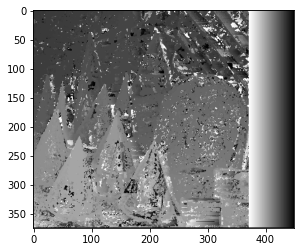

Block Radius=  2
Accuracy=  77.96444444444445


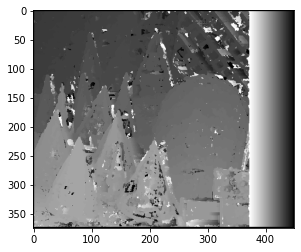

Block Radius=  4
Accuracy=  80.31881481481481


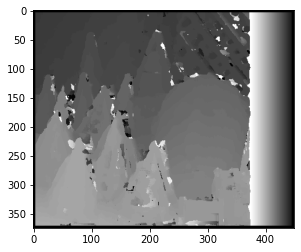

Block Radius=  6
Accuracy=  80.05274074074073


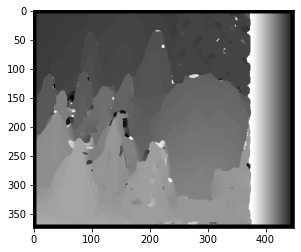

Block Radius=  8
Accuracy=  78.62400000000001


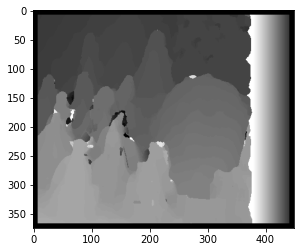

Block Radius=  10
Accuracy=  76.97481481481482


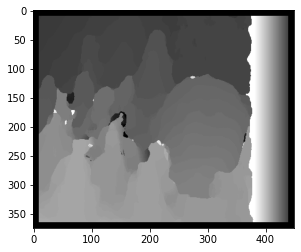

Block Radius=  20
Accuracy=  68.09777777777778


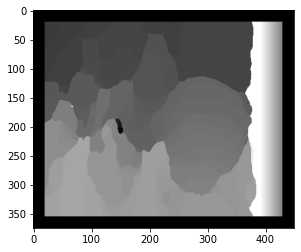

In [15]:
imgr,imgl,dispr,displ=load_image('../input/assignment1/data/cones/im2.png','../input/assignment1/data/cones/im6.png','../input/assignment1/data/cones/disp6.png','../input/assignment1/data/cones/disp2.png')
displ=3*displ/4 #Disparity should be dividedby 4 as  we had taken quatersize image but as we actually divide by 3 in the function,we will multipy by 3 and divide by 4
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


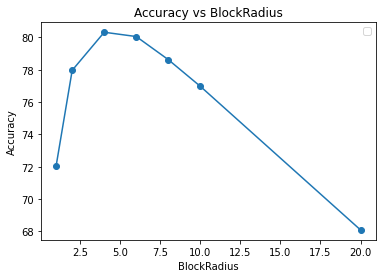

In [16]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 4 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Teddy Dataset

Block Radius=  1
Accuracy=  71.75585185185184


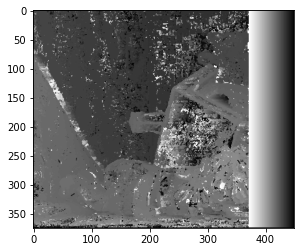

Block Radius=  2
Accuracy=  75.95140740740742


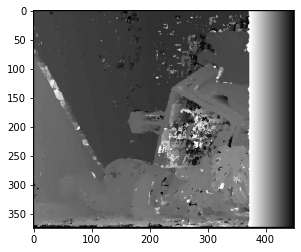

Block Radius=  4
Accuracy=  77.29362962962963


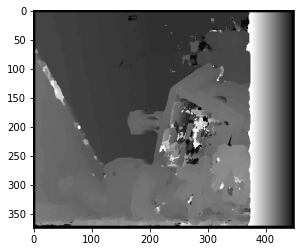

Block Radius=  6
Accuracy=  76.78399999999999


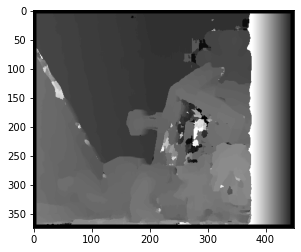

Block Radius=  8
Accuracy=  75.78014814814816


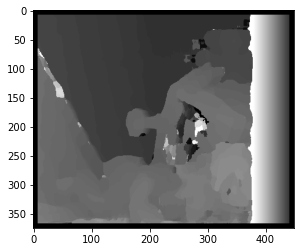

Block Radius=  10
Accuracy=  74.67792592592592


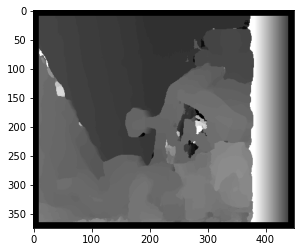

Block Radius=  20
Accuracy=  66.70103703703704


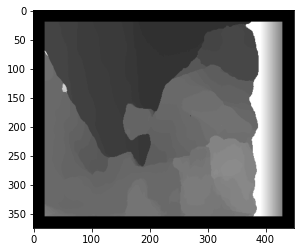

In [17]:
imgr,imgl,dispr,displ=load_image('../input/assignment1/data/teddy/im2.png','../input/assignment1/data/teddy/im6.png','../input/assignment1/data/teddy/disp6.png','../input/assignment1/data/teddy/disp2.png')
displ=3*displ/4#Disparity should be dividedby 4 as  we had taken quatersize image but as we actually divide by 3 in the function,we will multipy by 3 and divide by 4
accuracy,rads= estimate_at_various_radil(imgl,imgr,displ)


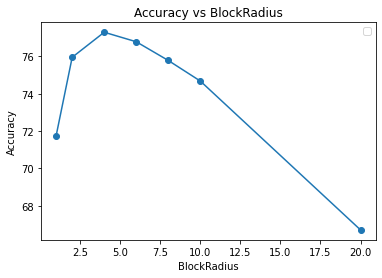

In [18]:
plt.plot(rads,accuracy,  marker='o')
plt.xlabel('BlockRadius')
plt.ylabel('Accuracy')
plt.title('Accuracy vs BlockRadius')
plt.legend()
plt.show()

From the above plot block radius 4 is best for the image. When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Inference

1. For the images where there were many small objects with many boundaries in the image, depth map looks good for small window size. But for the images where there were large objects in the image, depth map looks good for large window size

2.When the block size is less there were more finer details in image but noise is also more. With the large block size disparity map is much smoother but there were lesser details also the disparity map fails at boundaries.

# Stereo Rectification

# Detect Keypoints
Keypoints are the are spatial locations, or points in the image that define what is interesting or what stand out in the image. We will use SIFT algorithm to find the key points in both the images.

In [19]:
img1=cv2.imread('../input/assignment1/data/images/GardenL.png')
img2=cv2.imread('../input/assignment1/data/images/GardenR.png')
sift = cv2.SIFT_create()


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(cv2.UMat(img1), None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visuaize KeyPoints
In the below picture keypoints are shown in red in colour.

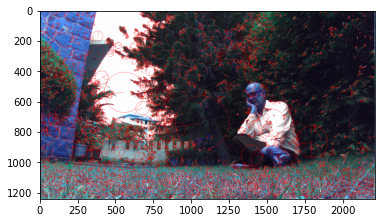

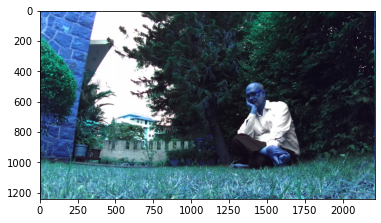

In [20]:
imgSift = cv2.drawKeypoints(img1, kp1, None,color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgSift)
plt.show()
plt.imshow(img1)
plt.show()

#  Matching Keypoints
We will match the keypoints between the two images by FLANN matcher.It sorts the best potential matches between similar keypoints in both images based on their distance using a K-nearest-neighbor search. However, this usually provides  more matches than we need. Therefore, the next few lines of code go through the keypoint matches and select the best ones

In [21]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Visuaize the Matches

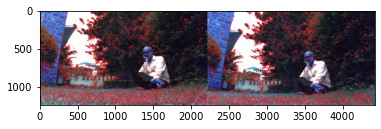

In [22]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
plt.imshow(keypoint_matches)
plt.show()

As we had the corresponding points in two images we will find the homorgraphy matrix corresponding to the two images. For finding  the homography matrix we   needs at least 7 pairs but works best with 8 or more.As we had more than 8 corresponding points we can find the Homography matrix. 

In [23]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Epilines
For efficient stereo matching epilines of the two images should be parallel. This
allows for the matching to happen only in one direction, along an epipolar line, greatly reducing the
search space. So we should align the images in such a manner so that the epilines are parallel.

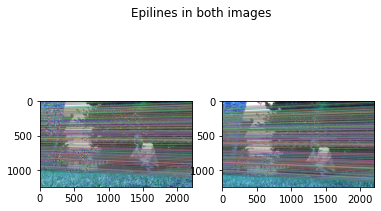

In [24]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c,d = img1src.shape
    img1color = img1src#cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = img2src#cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

We will use the stereoRectifyUncalibrated() algorithm to make epilines in both images horizontal.
To perform the rectification, we simply pass the matched points from both images as well as the fundamental matrix into the stereoRectifyUncalibrated() method. 

In [25]:
h1, w1,d1 = img1.shape
h2, w2,d2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))

In [26]:
img1=cv2.imread('../input/assignment1/data/images/GardenL.png',cv2.IMREAD_GRAYSCALE)
img2=cv2.imread('../input/assignment1/data/images/GardenR.png',cv2.IMREAD_GRAYSCALE)


In [27]:
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

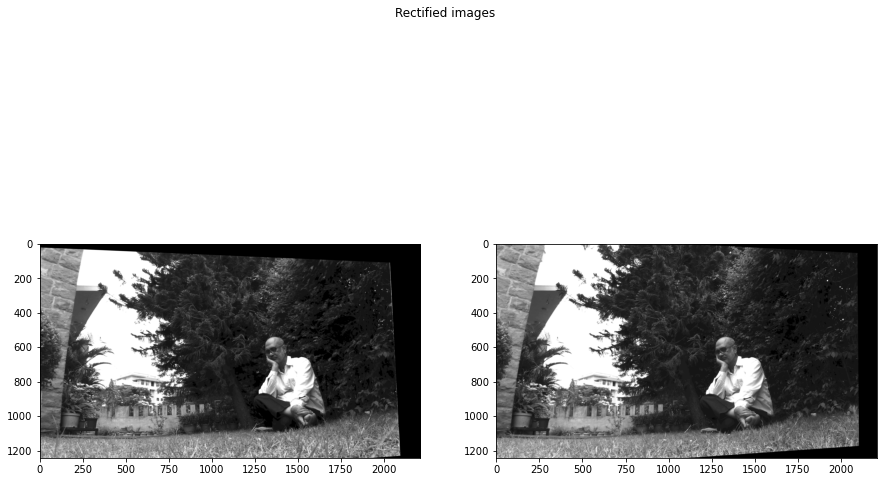

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

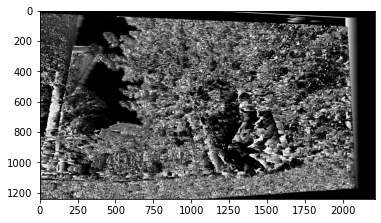

In [29]:
cv=disparity_estimation(img1_rectified,img2_rectified , 80, 1)
disp=esp_disp(cv)
        
plt.imshow(disp,cmap="gray")
plt.show()

# Similarly for Tanpura Image

In [34]:
img1=cv2.imread('../input/assignment1/data/images/TanpuraL.jpg')
img2=cv2.imread('../input/assignment1/data/images/TanpuraR.jpg')

sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(cv2.UMat(img1), None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]
h1, w1,d1 = img1.shape
h2, w2,d2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))
img1=cv2.imread('../input/assignment1/data/images/TanpuraL.jpg',cv2.IMREAD_GRAYSCALE)
img2=cv2.imread('../input/assignment1/data/images/TanpuraR.jpg',cv2.IMREAD_GRAYSCALE)

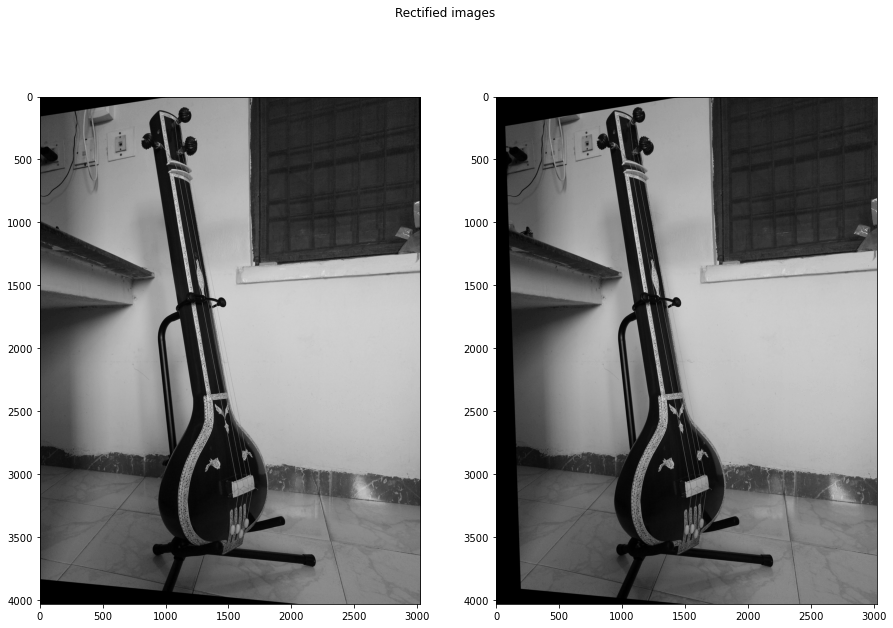

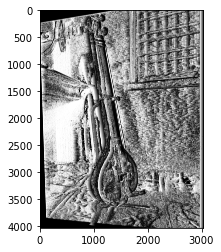

In [35]:
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()
cv=disparity_estimation(img1_rectified,img2_rectified , 80, 2)
disp=esp_disp(cv)
        
plt.imshow(disp,cmap="gray")
plt.show()